In [ ]:
#Load the dataset

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/HAM10000_metadata.csv
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/HAM10000_metadata.csv")

/content/drive/MyDrive/HAM10000_metadata.csv


In [ ]:
pip install kaggle


In [ ]:
#Load the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [04:24<00:00, 22.4MB/s]
100% 5.20G/5.20G [04:24<00:00, 21.1MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d ham10000




Streaming output truncated to the last 5000 lines.
  inflating: ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_002

In [ ]:
import os

# Assuming metadata is your DataFrame with image information
# Group by image_id to ensure each image is listed uniquely

# Load metadata
metadata = pd.read_csv("/content/drive/MyDrive/HAM10000_metadata.csv")

# Display metadata
print(metadata.head())

grouped_metadata = metadata.groupby('image_id').first().reset_index()


# Define the directories
part1_dir = '/content/ham10000/ham10000_images_part_1'
part2_dir = '/content/ham10000/ham10000_images_part_2'

# Create a function to find the correct path
def get_image_path(image_id):
    if os.path.exists(os.path.join(part1_dir, image_id + '.jpg')):
        return os.path.join(part1_dir, image_id + '.jpg')
    elif os.path.exists(os.path.join(part2_dir, image_id + '.jpg')):
        return os.path.join(part2_dir, image_id + '.jpg')
    else:
        return None  # Handle case where image doesn't exist in either part

# Apply the function to create the image_path column
grouped_metadata['image_path'] = grouped_metadata['image_id'].apply(get_image_path)

# Reorder and select relevant columns
final_metadata = grouped_metadata[['image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'image_path']]

# Display the first few rows of the restructured dataset
print(final_metadata.head())


       image_id   dx    dx_type   age     sex     localization  \
0  ISIC_0024306   nv  follow_up  45.0    male            trunk   
1  ISIC_0024307   nv  follow_up  50.0    male  lower extremity   
2  ISIC_0024308   nv  follow_up  55.0  female            trunk   
3  ISIC_0024309   nv  follow_up  40.0    male            trunk   
4  ISIC_0024310  mel      histo  60.0    male            chest   

                                          image_path  
0  /content/ham10000/ham10000_images_part_1/ISIC_...  
1  /content/ham10000/ham10000_images_part_1/ISIC_...  
2  /content/ham10000/ham10000_images_part_1/ISIC_...  
3  /content/ham10000/ham10000_images_part_1/ISIC_...  
4  /content/ham10000/ham10000_images_part_1/ISIC_...  


Image 1 - Label: 0


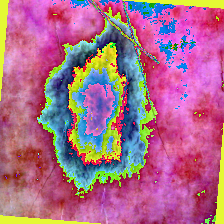

Image 2 - Label: 0


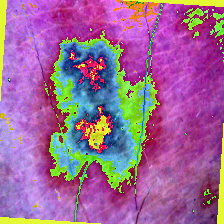

Image 3 - Label: 0


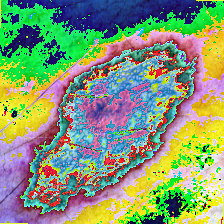

Image 4 - Label: 0


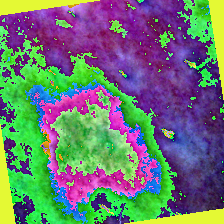

Image 5 - Label: 1


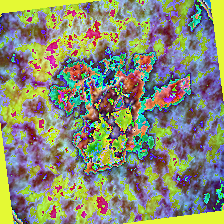

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import torchvision.transforms as transforms
import torch

class SimpleDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(self.metadata['dx'].unique())}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['image_path']  # Use the image path directly from metadata

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")

        image = Image.open(img_path).convert('RGB')
        label = self.metadata.iloc[idx]['dx']
        label = self.label_map[label]  # Convert label to an integer index

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor

import torchvision.transforms as transforms

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize the image to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),   # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image with mean and std of ImageNet dataset
])

# Assuming the metadata has been correctly prepared with image paths
dataset = SimpleDataset(metadata=final_metadata, transform=transform)

# Define a function to view images with labels
def view_images(dataset, num_images=5):
    for i in range(min(num_images, len(dataset))):
        image, label = dataset[i]  # Get the image tensor and label from the dataset

        # Convert tensor to PIL image
        image = transforms.ToPILImage()(image)

        # Display the image
        image.show()
        print(f"Image {i+1} - Label: {label}")

        # If running in a Jupyter notebook, use IPython.display to show the image inline
        try:
            from IPython.display import display
            display(image)
        except ImportError:
            pass

# View first few images with labels
view_images(dataset, num_images=5)


In [ ]:
from torch.utils.data import random_split , DataLoader

# Define the split ratio (e.g., 80% training and 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, len(dataset.metadata['dx'].unique()))  # Number of classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer)


Epoch 1/10, Loss: 1.1251
Epoch 2/10, Loss: 0.8115
Epoch 3/10, Loss: 0.7623
Epoch 4/10, Loss: 0.7201
Epoch 5/10, Loss: 0.6902
Epoch 6/10, Loss: 0.6674
Epoch 7/10, Loss: 0.6490
Epoch 8/10, Loss: 0.6263
Epoch 9/10, Loss: 0.5917
Epoch 10/10, Loss: 0.5650


In [ ]:
# Save only the model state dictionary
torch.save(model.state_dict(), 'simple_cnn_model_state_dict.pth')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models  # Import torchvision.models

# Define the EfficientNet model
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
num_classes = len(dataset.metadata['dx'].unique())  # Number of classes in the dataset
EFF_model = EfficientNetModel(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(EFF_model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Directly convert labels to LongTensor (assuming they are already numerical)
            labels = torch.LongTensor(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Train the model
train_model(EFF_model, train_loader, criterion, optimizer)

# Save the model
torch.save(EFF_model.state_dict(), 'efficientnet_model_state_dict.pth')

Epoch 1/10, Loss: 0.6888
Epoch 2/10, Loss: 0.5147
Epoch 3/10, Loss: 0.4498
Epoch 4/10, Loss: 0.3937
Epoch 5/10, Loss: 0.3473
Epoch 6/10, Loss: 0.3111
Epoch 7/10, Loss: 0.2724
Epoch 8/10, Loss: 0.2491
Epoch 9/10, Loss: 0.2233
Epoch 10/10, Loss: 0.2090


In [ ]:

# Define the DenseNet model
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.model = models.densenet121(pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
num_classes = len(dataset.metadata['dx'].unique())  # Number of classes in the dataset
DNS_model = DenseNetModel(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Train the model
train_model(DNS_model, train_loader, criterion, optimizer)

# Save the model
torch.save(DNS_model.state_dict(), 'densenet_model_state_dict.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 107MB/s] 


Epoch 1/10, Loss: 2.0213
Epoch 2/10, Loss: 2.0200
Epoch 3/10, Loss: 2.0218
Epoch 4/10, Loss: 2.0217
Epoch 5/10, Loss: 2.0234
Epoch 6/10, Loss: 2.0265
Epoch 7/10, Loss: 2.0204
Epoch 8/10, Loss: 2.0254
Epoch 9/10, Loss: 2.0250
Epoch 10/10, Loss: 2.0221


In [ ]:

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            # Move images and labels to the same device as the model
            images = images.to(device)  # Move images to GPU
            labels = labels.to(device)  # Move labels to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total)*100
    return accuracy

# Load models
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load('simple_cnn_model_state_dict.pth'))

efficientnet_model = EfficientNetModel(num_classes=len(dataset.metadata['dx'].unique()))
efficientnet_model.load_state_dict(torch.load('efficientnet_model_state_dict.pth'))

densenet_model = DenseNetModel(num_classes=len(dataset.metadata['dx'].unique()))
densenet_model.load_state_dict(torch.load('densenet_model_state_dict.pth'))

# Move models to the same device as the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)
efficientnet_model.to(device)
densenet_model.to(device)

# Evaluate models
cnn_accuracy = evaluate_model(cnn_model, test_loader)
efficientnet_accuracy = evaluate_model(efficientnet_model, test_loader)
densenet_accuracy = evaluate_model(densenet_model, test_loader)

print(f"SimpleCNN Accuracy: {cnn_accuracy:.4f}")
print(f"EfficientNet Accuracy: {efficientnet_accuracy:.4f}")
print(f"DenseNet Accuracy: {densenet_accuracy:.4f}")


SimpleCNN Accuracy: 72.7409
EfficientNet Accuracy: 86.4703
DenseNet Accuracy: 10.5342


In [ ]:
import pickle

# Assuming 'model' is your trained model
with open('efficientnet_model_state_dict.pkl', 'wb') as f:
    pickle.dump(EFF_model, f)

In [ ]:
from google.colab import files
files.download('efficientnet_model_state_dict.pth')  # Adjust filename if needed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the model
model.load_state_dict(torch.load('efficientnet_model_state_dict.pth', map_location=torch.device('cpu')), weights_only=True)


In [ ]:
from google.colab import files
files.download('efficientnet_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download('efficientnet_model_state_dict.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>